In [1]:
import pandas as pd
import numpy as np
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   tf.random.set_seed(rs)
   np.random.seed(rs)

# reset_random_seeds(rs)

dir_path = './data/humanModel/dataset_v0.csv'

In [2]:
data = pd.read_csv(dir_path)
data.columns = data.columns.str.replace(' ', '')
data.head()

,code,step,computer_x,computer_y,human_x,human_y,stag_x,stag_y,shrub1_x,shrub1_y,shrub2_x,shrub2_y,shrub3_x,shrub3_y,human_action
0,-N2gl9wHXMJoXRg5OyiP,1,4,0,0,0,2,2,1,4,3,0,1,2,40
1,-N2gl9wHXMJoXRg5OyiP,2,4,1,0,1,3,2,1,4,3,0,1,2,39
2,-N2gl9wHXMJoXRg5OyiP,3,4,2,1,1,3,1,1,4,3,0,1,2,40
3,-N2gl9wHXMJoXRg5OyiP,4,4,1,1,2,4,1,1,4,3,0,2,2,39
4,-N2gl9wHXMJoXRg5OyiP,5,4,0,2,2,4,1,1,4,3,0,3,3,39


In [3]:
data.columns

Index(['code', 'step', 'computer_x', 'computer_y', 'human_x', 'human_y',
       'stag_x', 'stag_y', 'shrub1_x', 'shrub1_y', 'shrub2_x', 'shrub2_y',
       'shrub3_x', 'shrub3_y', 'human_action'],
      dtype='object')

# Split into train, validation and test data

In [4]:
scaler = LabelEncoder()

X = data.iloc[:, 2:-1].values # Drop unused features ("code", "step").
y = scaler.fit_transform(data.iloc[:, -1].values) # Pop the target

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2, random_state = rs)

freqs = pd.DataFrame({"Training dataset": [(y_train == 0).sum(),(y_train == 1).sum(),(y_train == 2).sum(), (y_train == 3).sum()],
                      "Test dataset": [(y_test == 0).sum(),(y_test == 1).sum(),(y_test == 2).sum(),(y_test == 3).sum()],
                      "Total": [(y_train == 0).sum()+(y_test == 0).sum(),(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 2).sum()+(y_test == 2).sum(),(y_train == 3).sum()+(y_test == 3).sum()]},
                     index=["left", "up", "right", "down"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
left,55,21,76
up,71,15,86
right,68,18,86
down,80,15,95


# Transform target to one-hot encoding

In [5]:
# n_values = np.max(y_train) + 1
# y_train = np.eye(n_values)[y_train]

# n_values = np.max(y_test) + 1
# y_test = np.eye(n_values)[y_test]

In [6]:
print(len(y_train), 'training examples')
print(len(y_test), 'test examples')

274 training examples
69 test examples


In [7]:
type(y_train)

numpy.ndarray

# Build the model

In [8]:
input_shape = (X_train.shape[1])
num_classes = 4

X_input = Input(shape=input_shape)
X = X_input
# X = Dense(128, activation='relu')(X)
X = Dense(64, activation='relu')(X)
X = Dense(32, activation='relu')(X)
X = Dense(16, activation='relu')(X)
# Output Layer with # of actions: 4 nodes (left, right, up, down)
X = Dense(num_classes, activation="softmax")(X)

model = Model(inputs = X_input, outputs = X)

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 3,508
Trainable params: 3,508
Non-trainable params: 0
_________________________________________________________________


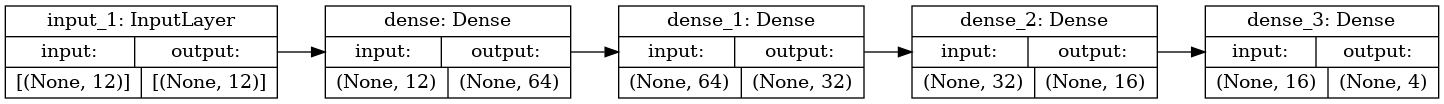

In [11]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Train the model

In [12]:
epochs = 80
batch_size = 64
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/80


/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


5/5 [==============================] - 0s 24ms/step - loss: 1.4544 - accuracy: 0.2372 - val_loss: 1.4014 - val_accuracy: 0.3043
Epoch 2/80
5/5 [==============================] - 0s 4ms/step - loss: 1.3913 - accuracy: 0.3029 - val_loss: 1.3873 - val_accuracy: 0.3478
Epoch 3/80
5/5 [==============================] - 0s 4ms/step - loss: 1.3690 - accuracy: 0.3394 - val_loss: 1.3783 - val_accuracy: 0.3333
Epoch 4/80
5/5 [==============================] - 0s 4ms/step - loss: 1.3564 - accuracy: 0.3504 - val_loss: 1.3740 - val_accuracy: 0.2899
Epoch 5/80
5/5 [==============================] - 0s 4ms/step - loss: 1.3438 - accuracy: 0.3723 - val_loss: 1.3718 - val_accuracy: 0.3333
Epoch 6/80
5/5 [==============================] - 0s 4ms/step - loss: 1.3323 - accuracy: 0.3978 - val_loss: 1.3691 - val_accuracy: 0.3333
Epoch 7/80
5/5 [==============================] - 0s 4ms/step - loss: 1.3221 - accuracy: 0.4088 - val_loss: 1.3651 - val_accuracy: 0.3333
Epoch 8/80
5/5 [============================

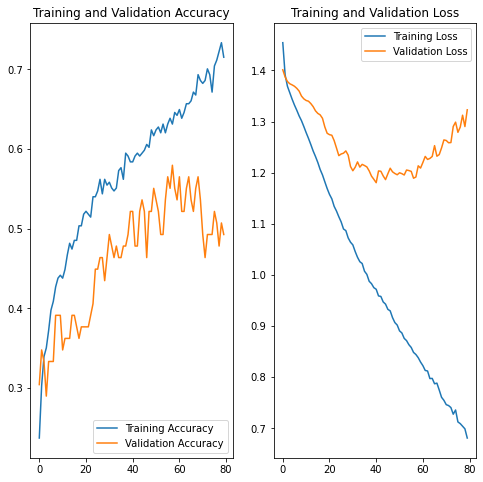

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 1ms/step - loss: 1.3231 - accuracy: 0.4928
Test accuracy : 0.49275362491607666


# Save the model

In [15]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/humanModel/model_v0.h5')

In [16]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [32]:
n=1
index = np.random.choice(X_test.shape[0], n, replace=False)
example = X_test[index]

predictions = model.predict(example)[0]
print(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.  True value: {}"
    .format(np.argmax(predictions), 100 * np.max(predictions), y_test[index])
)

[0.747 0.182 0.018 0.054]
This image most likely belongs to 0 with a 74.67 percent confidence.  True value: [0]
